In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [2]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_sizes = [256, 256]

lr = 0.001

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(3 * 32 * 32, hidden_layer_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_layer_sizes[0])
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes) - 1)])
        self.fc_out = nn.Linear(hidden_layer_sizes[-1], 10)
        
#         for i, l in enumerate(self.linears):
#             self.linears[i].weight.data.copy_(torch.eye(self.linears[i].weight.size(0)))

    def forward(self, x):
        activations = []
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc_in(x))
        activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        # x = self.bn1(x)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
            # x = self.bns[i](x)
        x = self.fc_out(x)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc_in): Linear (3072 -> 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (linears): ModuleList (
    (0): Linear (256 -> 256)
  )
  (bns): ModuleList (
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc_out): Linear (256 -> 10)
)


In [30]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = range(0, max(hidden_layer_sizes))
        nb = 100
        draws = 10000
        indexes1 = np.random.choice(self.train_activations.shape[0], nb)
        indexes2 = np.random.choice(self.train_activations.shape[0], nb)
        
        distances_layers = []
        for i in range(len(hidden_layer_sizes)):
            distances_layers += [np.abs(self.train_activations[indexes1,i] - self.train_activations[indexes2,i]).sum(1)]
            print('Layer : %d .1%% : %.1f, 1%% : %.1f, 10%% : %.1f ' % (i+1, np.percentile(distances_layers[i], .1), np.percentile(distances_layers[i], 1.), np.percentile(distances_layers[i], 10.)))
            print('Layer : %d E : %.1f, Std : %.1f' % (i+1, np.mean(distances_layers[i]), np.std(distances_layers[i])))
            
            real_mean = distances_layers[i].mean()
            # Permutation test :
            L = []
            
            random_bernouilli_1 = np.random.randint(2, size=(draws, nb, hidden_layer_sizes[i]))
            random_bernouilli_2 = np.random.randint(2, size=(draws, nb, hidden_layer_sizes[i]))
            random_distances_mean = np.abs(random_bernouilli_1 - random_bernouilli_2).sum(2).mean(1)
            print(random_distances_mean.shape)
            
            plt.hist(random_distances_mean, label='E_permut hist.', bins=np.arange(100, 150, 1.))
            plt.axvline(real_mean, color='red')
            plt.legend()
            plt.show()
            
            print('P-value Random Bernouilli vectors : %.4f' % (np.where(random_distances_mean < real_mean, 1., 0.).sum() / draws))
            
            
        data = np.vstack([distances_layers[i] for i in range(len(distances_layers))]).T
        plt.hist(data, bins, label=['Train Layer : {}'.format(i) for i in range(1, len(distances_layers) + 1)])
        
#         indexes1 = np.random.choice(self.test_activations.shape[0], 10000)
#         indexes2 = np.random.choice(self.test_activations.shape[0], 10000)
        
#         distances = np.abs(self.test_activations[indexes1] - self.train_activations[indexes2]).sum(1)
#         plt.hist(distances, bins, label='Test Activations')
        
        plt.legend()
        plt.title('Histogram of distances of activation patterns')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [32]:
if cuda:
    model.cuda()
    criterion.cuda()

In [33]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 630:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

Layer : 1 .1% : 87.1, 1% : 88.0, 10% : 100.0 
Layer : 1 E : 127.3, Std : 19.3
(10000,)


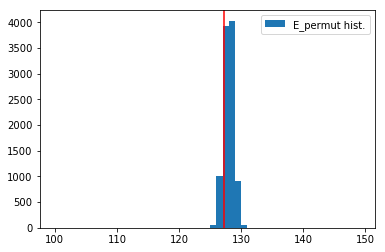

P-value Random Bernouilli vectors : 0.1873


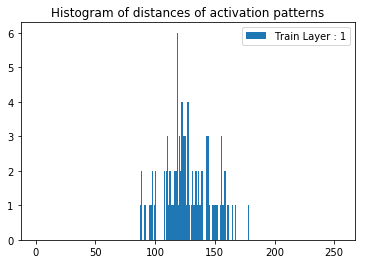

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.568990
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.194344
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.300345
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.887991
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.778253
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.195846
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.927511
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.148205

Test set: Average loss: 1.3701, Accuracy: 5217/10000 (52%)

Layer : 1 .1% : 69.4, 1% : 81.9, 10% : 103.0 
Layer : 1 E : 123.7, Std : 17.3
(10000,)


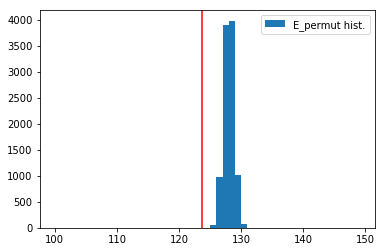

P-value Random Bernouilli vectors : 0.0000


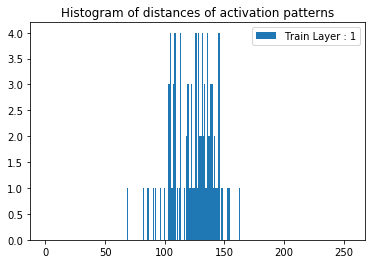

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.856284
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.940639
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.087736
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.218065
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.398526
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.927234
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.872950
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.106814

Test set: Average loss: 1.3600, Accuracy: 5237/10000 (52%)

Layer : 1 .1% : 76.0, 1% : 76.0, 10% : 93.9 
Layer : 1 E : 123.3, Std : 23.4
(10000,)


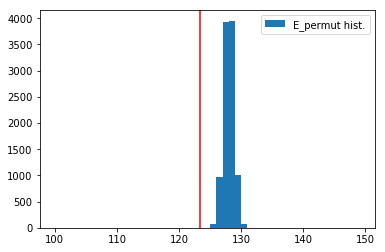

P-value Random Bernouilli vectors : 0.0000


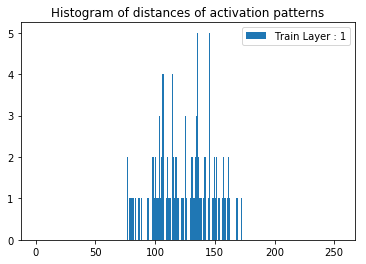

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.110321
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.404772
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.183376
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.723325
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.134557
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.061398
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.309317
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.230709

Test set: Average loss: 1.3608, Accuracy: 5264/10000 (53%)

Layer : 1 .1% : 62.1, 1% : 71.9, 10% : 99.0 
Layer : 1 E : 124.7, Std : 19.9
(10000,)


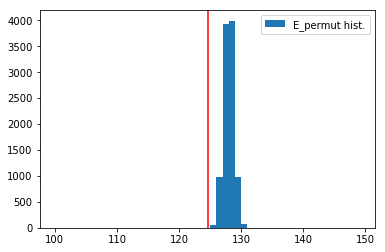

P-value Random Bernouilli vectors : 0.0001


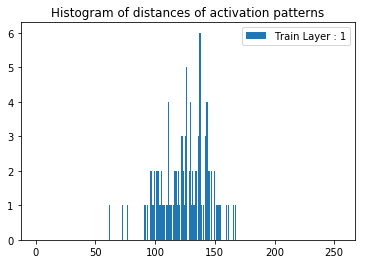

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.057131
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.084140
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.073631
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.327793
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.902018
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.923107
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.814230
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.864181

Test set: Average loss: 1.3885, Accuracy: 5152/10000 (52%)

Layer : 1 .1% : 78.1, 1% : 79.0, 10% : 95.0 
Layer : 1 E : 122.3, Std : 20.8
(10000,)


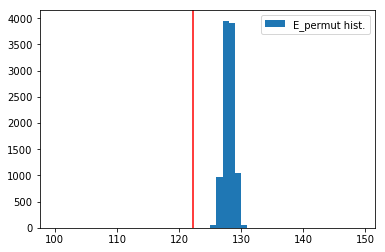

P-value Random Bernouilli vectors : 0.0000


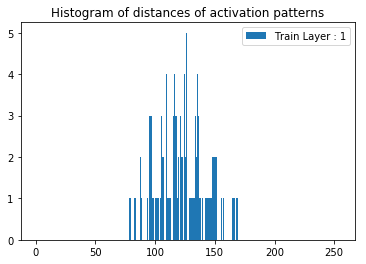

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.316838
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.931390
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.018867
Train Epoch: 5 [19200/50000 (38%)]	Loss: 0.853956
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.986143
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.299751


Process Process-66:
Process Process-65:
    img = self.transform(img)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/

Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.631846


    return self.type(type(self).__module__ + '.FloatTensor')
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/_utils.py", line 22, in _type
    new_type = _import_dotted_name(new_type)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/_utils.py", line 81, in _import_dotted_name


KeyboardInterrupt: 

    obj = __import__(components[0])
KeyboardInterrupt


In [34]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()